In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import os

# skimage
import skimage
import skimage.color
import skimage.transform
import skimage.feature
import skimage.io

C:\Users\Ayush\.conda\envs\tensorflow\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])
    
    
class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(3, 3),):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features= skimage.feature.hog(img,orientations=self.orientations,
                                pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block)
            
            return hog_features
        
        hfeatures = np.array([local_hog(x) for x in X])
        return hfeatures

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# pipeline model
image = skimage.io.imread(r'C:\Users\Ayush\OneDrive\Desktop\Image Classifier\Images\eagle.jpg')
# transform image into 80 x 80
image_resize = skimage.transform.resize(image,(80,80))
image_scale = 255*image_resize
image_transform = image_scale.astype(np.uint8)
# rgb to gray
gray = skimage.color.rgb2gray(image_transform)
# hog feature
feature_vector = skimage.feature.hog(gray,
                              orientations=10,
                              pixels_per_cell=(8,8),cells_per_block=(2,2))

In [7]:
feature_vector

array([0.20892749, 0.02576187, 0.25915192, ..., 0.04869078, 0.03815464,
       0.00625194])

In [8]:
import pickle
# load the model
model = pickle.load(open('dsa_image_classification_sgd.pickle','rb'))
scaler = pickle.load(open('dsa_scaler.pickle','rb'))

In [9]:
feature_vector.shape

(3240,)

In [10]:
scalex = scaler.transform(feature_vector.reshape(1,-1))
result = model.predict(scalex)

In [11]:
result

array(['eagle'], dtype='<U8')

In [12]:
# cal the probabilty 
decision_value = model.decision_function(scalex)

In [13]:
decision_value

array([[-179.14024362, -180.08225462,  -95.70207721, -175.7988467 ,
        -248.56794747, -210.90911088,  -48.6621931 ,    6.42394676,
        -273.70101419, -161.25846917, -266.68674936,  -94.36896353,
        -248.32537998, -157.15616144,  -97.46491225,  -81.26496126,
        -163.84462486, -207.29276828, -170.77337665, -348.33882472]])

In [14]:
labels = model.classes_

In [15]:
decision_value = decision_value.flatten()

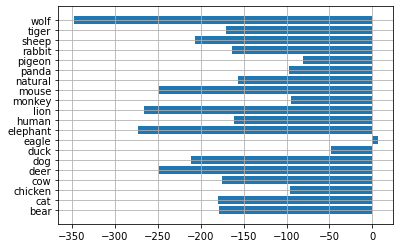

In [16]:
plt.barh(labels,decision_value)
plt.grid()

In [17]:
# cal. z score
z = scipy.stats.zscore(decision_value)
prob_value = scipy.special.softmax(z)
prob_value

array([0.02738433, 0.02707553, 0.07477208, 0.02850834, 0.01187177,
       0.01868125, 0.13172758, 0.2556713 , 0.00877229, 0.03396197,
       0.00954521, 0.07598176, 0.01190648, 0.03568132, 0.07320199,
       0.08896529, 0.03292091, 0.01951251, 0.03028631, 0.00357179])

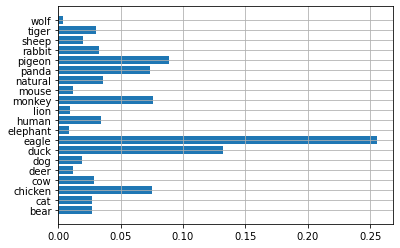

In [18]:
plt.barh(labels,prob_value)
plt.grid()

In [19]:
# top five probabilty values
top_5_prob_ind = prob_value.argsort()[::-1][:5]

In [20]:
top_5_prob_ind

array([ 7,  6, 15, 11,  2], dtype=int64)

In [21]:
top_labels = labels[top_5_prob_ind]
top_prob = prob_value[top_5_prob_ind]

In [22]:
top_prob,top_labels

(array([0.2556713 , 0.13172758, 0.08896529, 0.07598176, 0.07477208]),
 array(['eagle', 'duck', 'pigeon', 'monkey', 'chicken'], dtype='<U8'))

In [23]:
top_dict = dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,3)})

In [24]:
top_dict

{'eagle': 0.256,
 'duck': 0.132,
 'pigeon': 0.089,
 'monkey': 0.076,
 'chicken': 0.075}

In [25]:
def pipeline_model(path,scaler_transform,model_sgd):
    # pipeline model
    image = skimage.io.imread(path)
    # transform image into 80 x 80
    image_resize = skimage.transform.resize(image,(80,80))
    image_scale = 255*image_resize
    image_transform = image_scale.astype(np.uint8)
    # rgb to gray
    gray = skimage.color.rgb2gray(image_transform)
    # hog feature
    feature_vector = skimage.feature.hog(gray,
                                  orientations=10,
                                  pixels_per_cell=(8,8),cells_per_block=(2,2))
    # scaling
    
    scalex = scaler_transform.transform(feature_vector.reshape(1,-1))
    result = model_sgd.predict(scalex)
    # decision function # confidence
    decision_value = model_sgd.decision_function(scalex).flatten()
    labels = model_sgd.classes_
    # probability
    z = scipy.stats.zscore(decision_value)
    prob_value = scipy.special.softmax(z)
    
    # top 5
    top_5_prob_ind = prob_value.argsort()[::-1][:5]
    top_labels = labels[top_5_prob_ind]
    top_prob = prob_value[top_5_prob_ind]
    # put in dictornary
    top_dict = dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,3)})
    
    return top_dict

In [27]:
res = pipeline_model(r'C:\Users\Ayush\OneDrive\Desktop\Image Classifier\Images\eagle.jpg',scaler,model)
res

{'eagle': 0.256,
 'duck': 0.132,
 'pigeon': 0.089,
 'monkey': 0.076,
 'chicken': 0.075}